In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/kaggle/nih-chest-xrays-tfrecords.zip", 'r')
zip_ref.extractall("/content/nih-chest-xrays-tfrecords")
zip_ref.close()

In [3]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.7 MB 10.8 MB/s 
     |████████████████████████████████| 140 kB 47.5 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 180 kB 49.8 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=6da4bbb8d9b45ce118f1301830c4affceaff2cbf1e94d696cb7777e9c7497e3e
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=25471a1c699f0b931ad424182fd944bd6fb2b5226f697c90c308cceaf51b95a6
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [4]:
wandb.init(project="cv_hemanth")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/kaggle/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
df= pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv')
df.head()

,Unnamed: 0,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,../input/data/images_001/images/00000001_000.png,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,../input/data/images_001/images/00000001_001.png,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,../input/data/images_001/images/00000001_002.png,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,../input/data/images_001/images/00000002_000.png,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,../input/data/images_001/images/00000003_000.png,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [7]:
dfk=df.iloc[:,1:]

In [8]:
dfk

,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
112116,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
112117,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
112118,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [9]:
cols = dfk.columns
num_cols = dfk._get_numeric_data().columns
char_cols=list(set(cols) - set(num_cols))
char_cols

[]

In [10]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
def encode(df):
    for i in cols:
        df[i]= le.fit_transform(df[i])
    return df

In [11]:
encode(dfk)

,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112117,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112118,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
df=pd.concat([df.iloc[:,0],dfk], axis=1)

In [13]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import seaborn as sns
import random
from functools import partial
import sys
from numpy import load
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import time as timer


In [14]:
start_time = timer.time()

In [15]:
data_dir = '/content/nih-chest-xrays-tfrecords/'

image_dir = data_dir + 'data/'

tfrlist_suffix = os.listdir(image_dir)

print('TFRecord file count: ' + str(len(tfrlist_suffix)))

TFRecord file count: 256


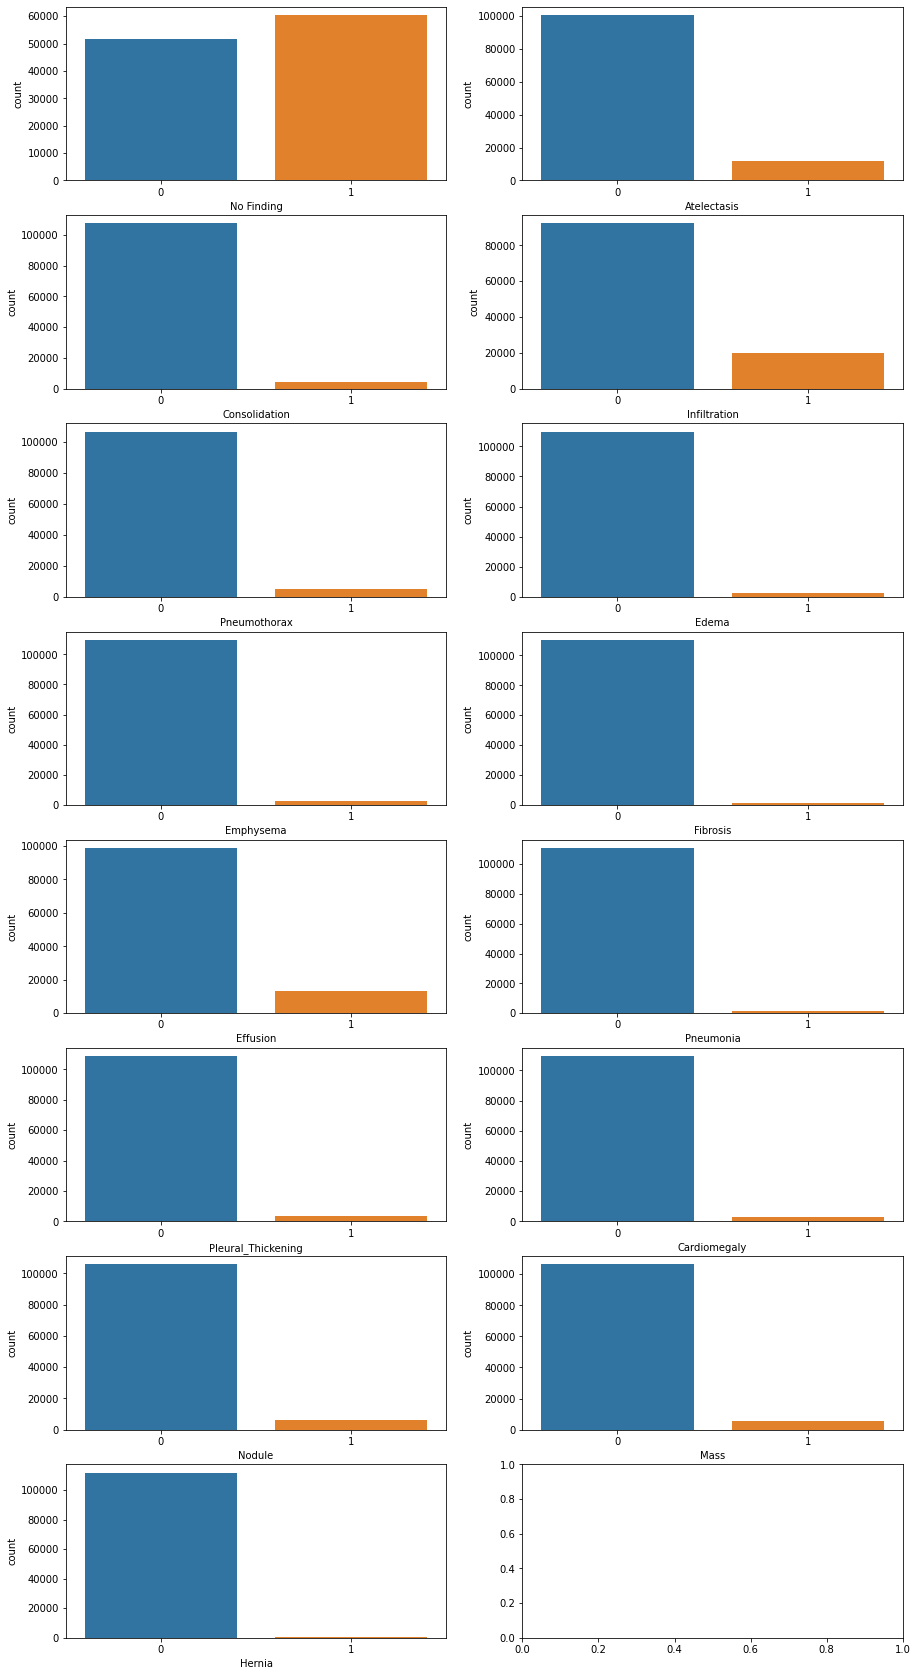

In [16]:
heads = list(df.columns)[1:]
cols = int(np.ceil(len(heads)/2))

_, axs = plt.subplots(cols,2, figsize=(15, 30))

for i, _ in enumerate(heads):
    if i % 2 == 0:
        sns.countplot(x=heads[i], data=df, ax=axs[int(i/2),0])
    else:
        sns.countplot(x=heads[i], data=df, ax=axs[int((i-1)/2),1])

In [17]:
heads = list(df.columns)[2:]

In [18]:
tfrlist = [image_dir + x for x in tfrlist_suffix]

FILENAMES = tf.io.gfile.glob(tfrlist)

In [19]:
ALL = list(range(len(FILENAMES)))

TRAIN_AND_VALID_INDEX = random.sample(ALL, int(len(ALL) * 0.8))
TEST_INDEX = list(set(ALL) - set(TRAIN_AND_VALID_INDEX))

TRAIN_INDEX = random.sample(TRAIN_AND_VALID_INDEX, int(len(TRAIN_AND_VALID_INDEX) * 0.9))
VALID_INDEX = list(set(TRAIN_AND_VALID_INDEX) - set(TRAIN_INDEX))

In [20]:
TRAINING_FILENAMES, VALID_FILENAMES, TEST_FILENAMES = [FILENAMES[index] for index in TRAIN_INDEX], [FILENAMES[index] for index in VALID_INDEX], [FILENAMES[index] for index in TEST_INDEX]

In [21]:
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 183
Validation TFRecord Files: 21
Test TFRecord Files: 52


In [22]:
feature_description = {}

for elem in list(df.columns)[2:]:
    feature_description[elem] = tf.io.FixedLenFeature([], tf.int64)
    
feature_description['image'] = tf.io.FixedLenFeature([], tf.string)

In [23]:
BATCH_SIZE = 32
IMAGE_ONE_AXIS = 100
IMAGE_SIZE = [IMAGE_ONE_AXIS, IMAGE_ONE_AXIS]
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [24]:
def read_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    
    label = []
    
    for val in heads:
        label.append(example[val])
    
    return image, label


In [25]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    
    return dataset

In [26]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [27]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_dataset(TEST_FILENAMES)

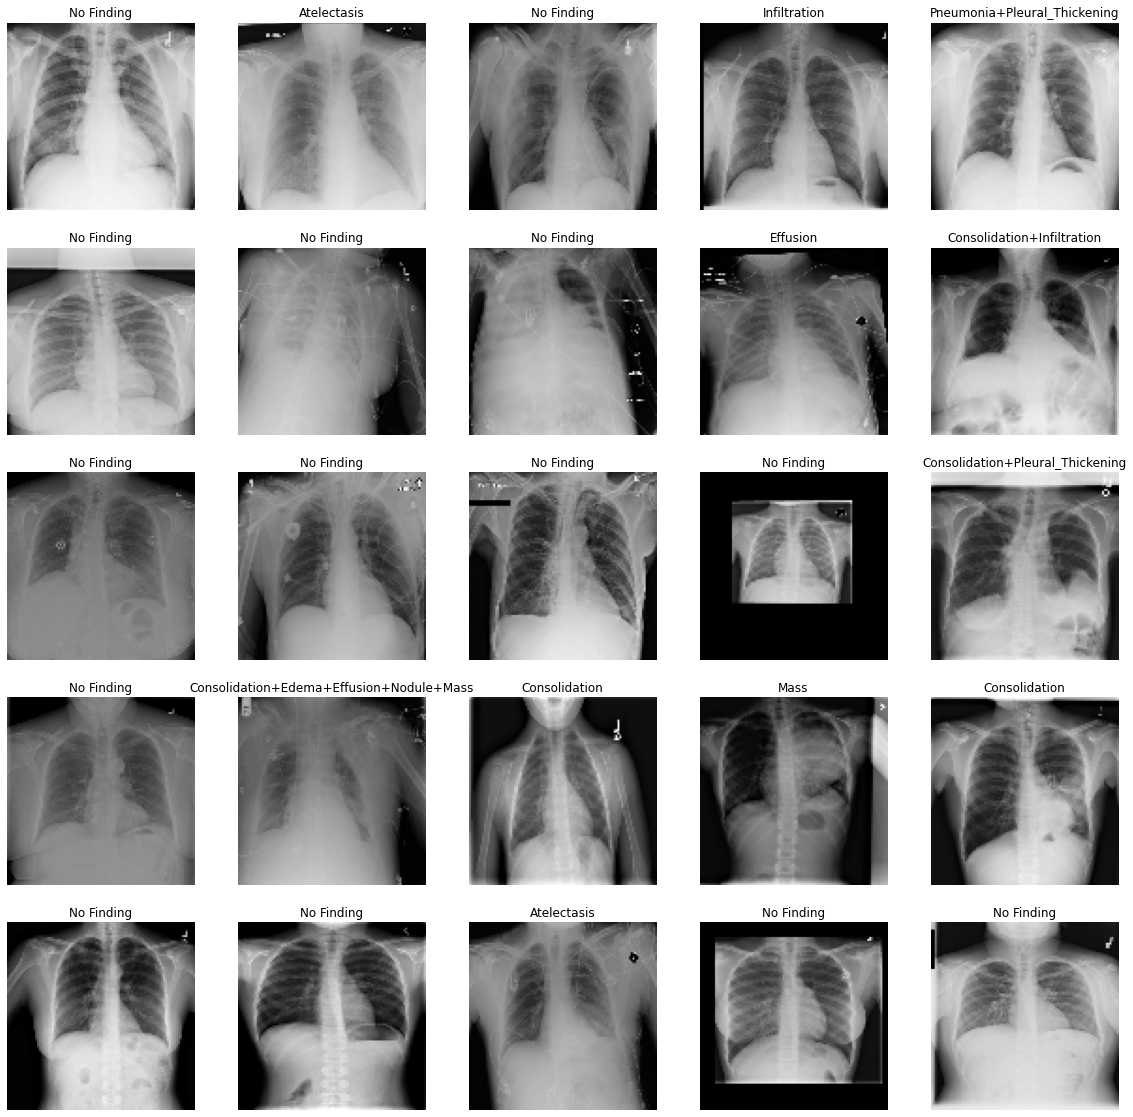

In [28]:
image_viz, label_viz = next(iter(train_dataset))

def show_batch(X, Y):
    plt.figure(figsize=(20, 20))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(X[n])
        
        result = [x for i, x in enumerate(heads) if Y[n][i]]
        title = "+".join(result)
        
        if result == []: title = "No Finding"
        
        plt.title(title)
        plt.axis("off")

show_batch(image_viz.numpy(), label_viz.numpy())

In [29]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=5, decay_rate=0.96, staircase=True
)

In [30]:
def define_model(in_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), out_shape=len(heads)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    config = wandb.config
    config.learning_rate = 0.01
    model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=lr_schedule),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name="auc")])
    return model

In [31]:
train_size = sum(1 for _ in tf.data.TFRecordDataset(TRAINING_FILENAMES))
validation_size = sum(1 for _ in tf.data.TFRecordDataset(VALID_FILENAMES))

epoch_steps = int(np.ceil(train_size/BATCH_SIZE))
validation_steps = int(np.ceil(validation_size/BATCH_SIZE))

epochs = 10

print("steps_per_epoch: " + str(epoch_steps))
print("validation_steps: " + str(validation_steps))

steps_per_epoch: 2505
validation_steps: 288


In [32]:
model = define_model()

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    validation_steps = validation_steps,callbacks=[WandbCallback()]
)

Epoch 1/10
2505/2505 [==============================] - 306s 108ms/step - loss: 0.1848 - auc: 0.7415 - val_loss: 0.1855 - val_auc: 0.7423
Epoch 2/10
2505/2505 [==============================] - 276s 109ms/step - loss: 0.1832 - auc: 0.7456 - val_loss: 0.1855 - val_auc: 0.7423
Epoch 3/10
2505/2505 [==============================] - 277s 109ms/step - loss: 0.1832 - auc: 0.7456 - val_loss: 0.1855 - val_auc: 0.7423
Epoch 4/10
2505/2505 [==============================] - 290s 114ms/step - loss: 0.1832 - auc: 0.7456 - val_loss: 0.1855 - val_auc: 0.7423
Epoch 5/10
Epoch 5/10
2505/2505 [==============================] - 286s 112ms/step - loss: 0.1832 - auc: 0.7456 - val_loss: 0.1855 - val_auc: 0.7423
Epoch 6/10
Epoch 6/10
2505/2505 [==============================] - 286s 112ms/step - loss: 0.1832 - auc: 0.7456 - val_loss: 0.1855 - val_auc: 0.7423
Epoch 7/10
Epoch 7/10
2505/2505 [==============================] - 287s 113ms/step - loss: 0.1832 - auc: 0.7456 - val_loss: 0.1855 - val_auc: 0.7423
E

In [33]:
_, test_auc = model.evaluate(test_dataset, verbose=0)
test_acc = model.evaluate(test_dataset)
print('Test :', test_acc)
print('Test auc:', test_auc)

712/712 [==============================] - 59s 76ms/step - loss: 0.1850 - auc: 0.7460
Test : [0.18497750163078308, 0.7459873557090759]
Test auc: 0.7459873557090759
Test : [0.18497750163078308, 0.7459873557090759]
Test auc: 0.7459873557090759


In [ ]:
# plot loss
ax = plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
ax.axes.xaxis.set_visible(False)

# plot accuracy
plt.subplot(212)
plt.title('AUC')
plt.plot(history.history['auc'], color='blue', label='train')
plt.plot(history.history['val_auc'], color='orange', label='validation')

In [35]:
fitted_model = model.predict(test_dataset)

In [ ]:
image_viz, label_viz = next(iter(test_dataset))

def show_batch(X, Y_act):
    plt.figure(figsize=(25, 30))
    for n in range(9):
        
        ax = plt.subplot(3, 3, n + 1)
        ax = plt.imshow(X[n])
        
        result = [x for i, x in enumerate(heads) if Y_act[n][i]]
        
        title = "+".join(result)
        
        if result == []: title = "No Finding"
        
        title = "Actual:\n" + title
        
        title += "\n\n Prediction:\n" + str(fitted_model[n]) + "\n\n My interpretation:\n"
        
        threshold = 0.5
        
        result = []
        for i, _ in enumerate(heads):
            if fitted_model[n][i] > threshold:
                result.append(1)
            else:
                result.append(0)
        
        result = np.asarray(result)

        if np.linalg.norm(result) == 0:
            title += "No Finding"
        else:
            result = [x for i, x in enumerate(heads) if result[i]]
            additional_title = "+".join(result)
            title += additional_title
            
        plt.title(title)
        plt.axis("off")

show_batch(image_viz.numpy(), label_viz.numpy())

In [ ]:
end_time = timer.time()

time = end_time - start_time

day = time // (24 * 3600)
time = time % (24 * 3600)
hour = time // 3600
time %= 3600
minutes = time // 60
time %= 60
seconds = np.round(time,0)
print(f"Total code execution time: {day} days, {hour} hours, {minutes} minutes, {seconds} seconds")